# PFDD - Real-Time Object Detection + Image Classification with TensorFlow 

This notebook is intended to provide a brief look into Computer Vision with enhanced transfer learning using TensorFlow.


When it comes to CV tasks, PyTorch is my personal preference -as far as image classification and object detection are concerned. But with TF2's massive progession recently, as well as TFHub's open access to thousands of pre-trained models, the simplicity of generating accurate predictive results through transfer learning is a massive step forward in ML.

In [1]:
# modules used
import os
import pandas as pd
import numpy as np
import PIL
import PIL.Image
import tensorflow as tf
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import posixpath
import cv2
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report, roc_curve
from sklearn.model_selection import learning_curve, cross_val_score, GridSearchCV
from sklearn.model_selection import train_test_split, GroupKFold, KFold
from keras_preprocessing.image import ImageDataGenerator
import tensorflow_hub as hub
from sklearn.preprocessing import LabelBinarizer



import warnings
warnings.filterwarnings('ignore')

Image data - Directory and path

In [2]:
# image file names + extensions
images = os.listdir("../input/train-images/Train_Images")

# image directory
image_directory = Path('../input/train-images/Train_Images')

# image full path
image_filepaths = list(image_directory.glob(r'**/*.jpg'))

In [3]:
# append all image names to list
images_list = []

for f in images:  
    exc_name = f.split('/')[-1].split(',')
    images_list.append(''.join(exc_name))

The data used had a dataframe with all the image ids and their respective labels

In [4]:
train = pd.read_csv('../input/ffpd-od/Train (6).csv')

In [5]:
# Extracting the id from the image name
mapping = {f.split(".")[0]: f for f in images_list} 
train['img_names'] = pd.Series() 


In [6]:
for image_id, img_filename in mapping.items():
    train.loc[train.Image_ID == image_id, "img_names"] = img_filename

*Terrible of me to partition my code into these many little cells. 
Uncharacteristic on my part, but unacceptable behavior nonetheless.*

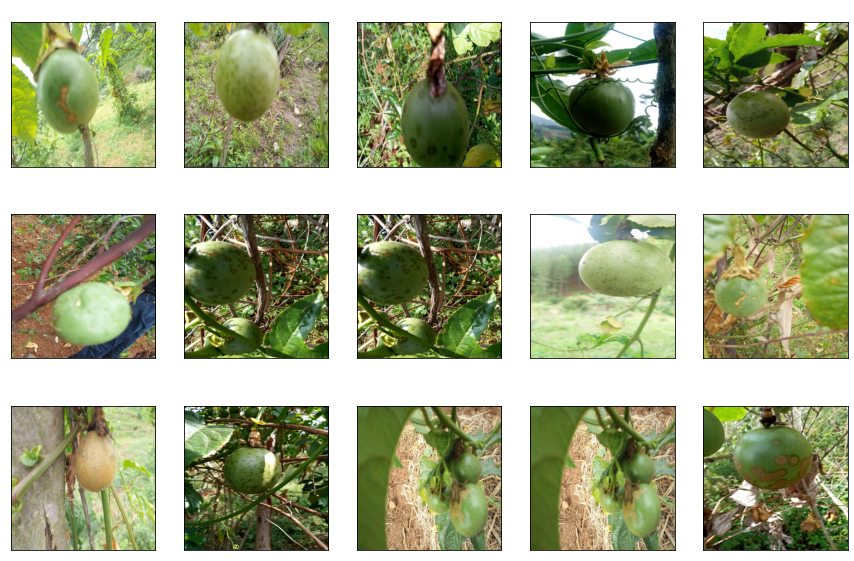

In [7]:
# some visuals
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15,10), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(posixpath.join(image_directory, train.img_names[i])))
    ax.set_title(train['class'][i], color="white")
    
plt.show()

Some EDA..

As tidy and insightful as dataprep's EDA is, i will not run this cell, as it will triple the size of the notebook.

In [ ]:
# !pip install dataprep
# from dataprep.eda import create_report
# create_report(train)

In [9]:
train = train.rename(columns={'class': 'fruit_class'})

In [10]:
# image processing

# experiment
img_healthy = cv2.imread(posixpath.join(image_directory, train.img_names[22]))
img_woody = cv2.imread(posixpath.join(image_directory, train.img_names[74]))
img_spotty = cv2.imread(posixpath.join(image_directory, train.img_names[33]))

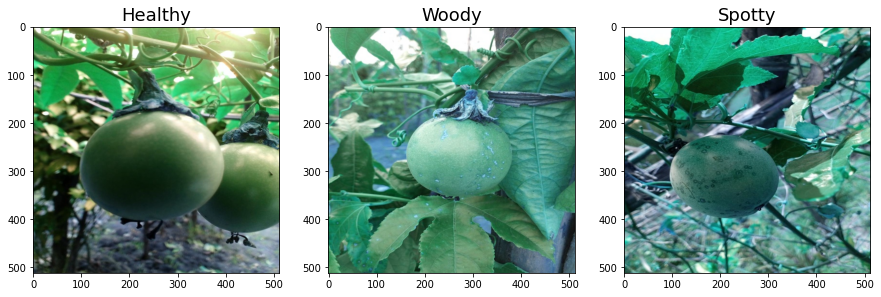

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(15,15))
axes[0].imshow(img_healthy)
axes[0].set_title("Healthy", fontsize = 18)
 
axes[1].imshow(img_woody)
axes[1].set_title("Woody", fontsize = 18)

axes[2].imshow(img_spotty)
axes[2].set_title("Spotty", fontsize = 18)

    
plt.show()



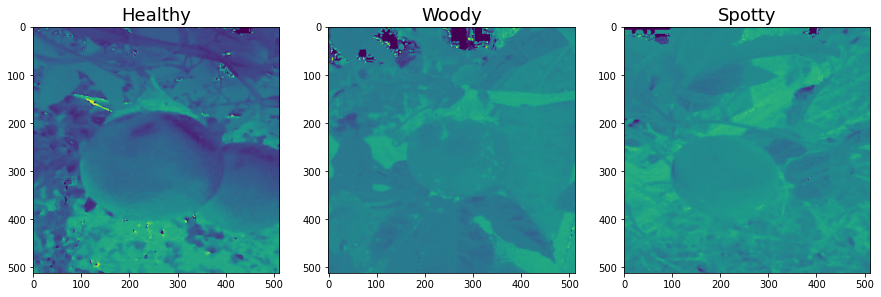

In [12]:
# plot the hue channel
img_healthy_hsv = cv2.cvtColor(img_healthy, cv2.COLOR_RGB2HSV)
img_woody_hsv = cv2.cvtColor(img_woody, cv2.COLOR_RGB2HSV)
img_spotty_hsv = cv2.cvtColor(img_spotty, cv2.COLOR_RGB2HSV)

hue_healthy = img_healthy_hsv[:,:,0]
hue_woody = img_woody_hsv[:,:,0]
hue_spotty = img_spotty_hsv[:,:,0]

fig, axes = plt.subplots(1, 3, figsize=(15,15))
axes[0].imshow(hue_healthy)
axes[0].set_title("Healthy", fontsize = 18)
 
axes[1].imshow(hue_woody)
axes[1].set_title("Woody", fontsize = 18)

axes[2].imshow(hue_spotty)
axes[2].set_title("Spotty", fontsize = 18)

    
plt.show()

Green. Green everywhere.

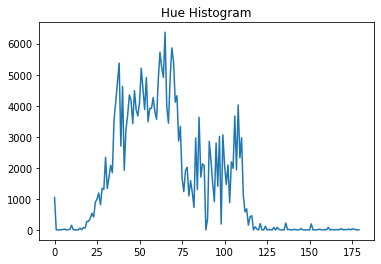

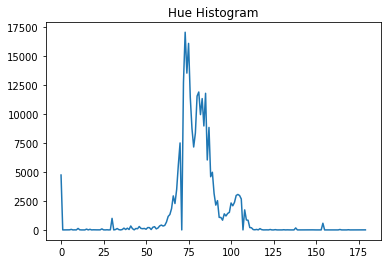

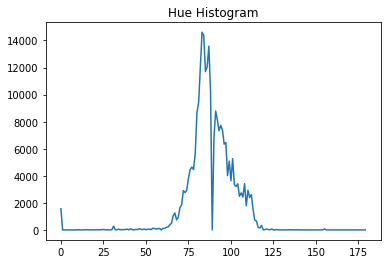

In [13]:
hist_h, _ = np.histogram(hue_healthy, bins = 180, normed = False)
plt.title("Hue Histogram")
plt.plot(hist_h)
plt.show()

hist_w, _ = np.histogram(hue_woody, bins = 180, normed = False)
plt.title("Hue Histogram")
plt.plot(hist_w)
plt.show()

hist_s, _ = np.histogram(hue_spotty, bins = 180, normed = False)
plt.title("Hue Histogram")
plt.plot(hist_s)
plt.show()

Almost all the pixel values are concentrated around the green channel. 70 - 120.

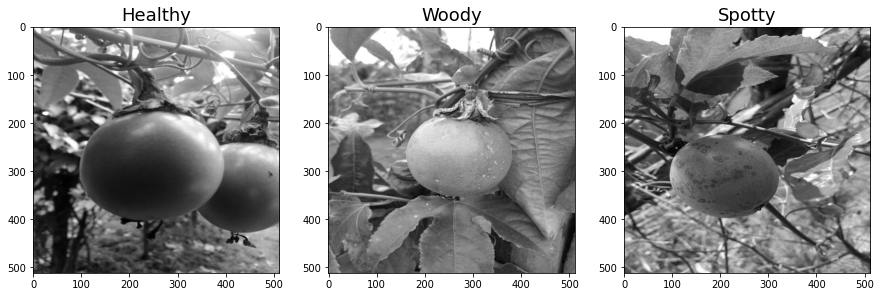

In [15]:
# removing all the colored channels
img_healthy_gray = cv2.cvtColor(img_healthy, cv2.COLOR_BGR2GRAY)
img_woody_gray = cv2.cvtColor(img_woody, cv2.COLOR_BGR2GRAY)
img_spotty_gray = cv2.cvtColor(img_spotty, cv2.COLOR_BGR2GRAY)

fig, axes = plt.subplots(1, 3, figsize=(15,15))
axes[0].imshow(img_healthy_gray, cmap='gray')
axes[0].set_title("Healthy", fontsize = 18)
 
axes[1].imshow(img_woody_gray, cmap='gray')
axes[1].set_title("Woody", fontsize = 18)

axes[2].imshow(img_spotty_gray, cmap='gray')
axes[2].set_title("Spotty", fontsize = 18)

    
plt.show()

Color transformations below; not to much effect

In [16]:
img_healthy_hsv = cv2.cvtColor(img_healthy, cv2.COLOR_BGR2HSV)
img_woody_hsv = cv2.cvtColor(img_woody, cv2.COLOR_BGR2HSV)
img_spotty_hsv = cv2.cvtColor(img_spotty, cv2.COLOR_BGR2HSV)

hue_h = img_healthy_hsv[:,:,0]
hue_w = img_woody_hsv[:,:,0]
hue_s = img_spotty_hsv[:,:,0]

val_h = img_healthy_hsv[:,:,2]
val_w = img_woody_hsv[:,:,2]
val_s = img_spotty_hsv[:,:,2]

sat_h = img_healthy_hsv[:,:,1]
sat_w = img_woody_hsv[:,:,1]
sat_s = img_spotty_hsv[:,:,1]


hue_h = hue_h + 10
hue_w = hue_w + 10
hue_s = hue_s - 100

val_h = val_h * 0.6
val_w = val_w * 0.3
val_s = val_s * 1.6

sat_h = sat_h - 96
sat_w = sat_w - 96
sat_s = sat_s + 96

cond_h = hue_h[:, :] < 0
hue_h[cond_h] = 0

cnd_h = val_h[:,:] > 255
val_h[cnd_h] = 255

cond_w = hue_w[:, :] < 0
hue_w[cond_w] = 0

cnd_w = val_w[:,:] > 255
val_w[cnd_w] = 255

cond_s = hue_s[:, :] < 0
hue_s[cond_s] = 0

cnd_s = val_s[:,:] > 255
val_s[cnd_s] = 255

img_healthy_hsv[:,:,0] = hue_h
img_woody_hsv[:,:,0] = hue_w
img_spotty_hsv[:,:,0] = hue_s

img_healthy_hsv[:,:,2] = val_h
img_woody_hsv[:,:,2] = val_w
img_spotty_hsv[:,:,2] = val_s


img_healthy_rgb = cv2.cvtColor(img_healthy_hsv, cv2.COLOR_HSV2RGB)
img_woody_rgb = cv2.cvtColor(img_woody_hsv, cv2.COLOR_HSV2RGB)
img_spotty_rgb = cv2.cvtColor(img_spotty_hsv, cv2.COLOR_HSV2RGB)

img_healthy_gray = cv2.cvtColor(img_healthy_rgb, cv2.COLOR_RGB2GRAY)
img_woody_gray = cv2.cvtColor(img_woody_rgb, cv2.COLOR_RGB2GRAY)
img_spotty_gray = cv2.cvtColor(img_spotty_rgb, cv2.COLOR_RGB2GRAY)


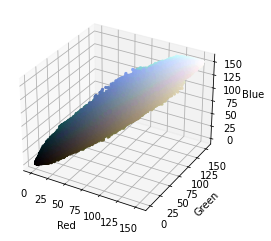

In [17]:
r, g, b = cv2.split(img_healthy_rgb)
fig = plt.figure()
axis = fig.add_subplot(1, 1, 1, projection="3d")

pixel_colors = img_healthy_rgb.reshape((np.shape(img_healthy_rgb)[0]*np.shape(img_healthy_rgb)[1], 3))
norm = colors.Normalize(vmin=-1.,vmax=1.)
norm.autoscale(pixel_colors)
pixel_colors = norm(pixel_colors).tolist()

axis.scatter(r.flatten(), g.flatten(), b.flatten(), facecolors=pixel_colors, marker=".")
axis.set_xlabel("Red")
axis.set_ylabel("Green")
axis.set_zlabel("Blue")
plt.show()

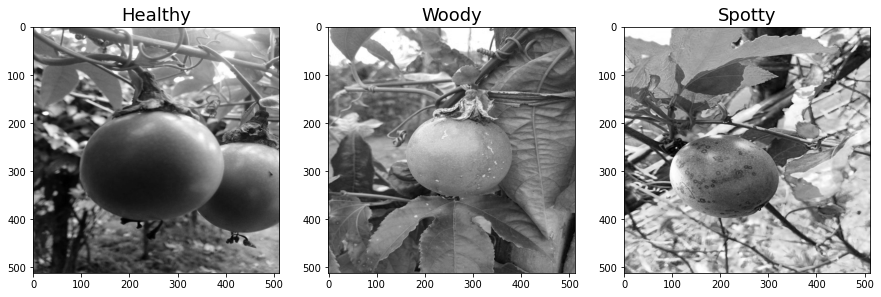

In [18]:
img_healthy_gray = cv2.cvtColor(img_healthy_rgb, cv2.COLOR_RGB2GRAY)
img_woody_gray = cv2.cvtColor(img_woody_rgb, cv2.COLOR_RGB2GRAY)
img_spotty_gray = cv2.cvtColor(img_spotty_rgb, cv2.COLOR_RGB2GRAY)

fig, axes = plt.subplots(1, 3, figsize=(15,15))
axes[0].imshow(img_healthy_gray, cmap = "gray")
axes[0].set_title("Healthy", fontsize = 18)
 
axes[1].imshow(img_woody_gray,  cmap = "gray")
axes[1].set_title("Woody", fontsize = 18)

axes[2].imshow(img_spotty_gray,  cmap = "gray")
axes[2].set_title("Spotty", fontsize = 18)

    
plt.show()

Below were some write operations of the transformed images onto the disk

In [ ]:
# for index, img in train.iterrows():          
#     if (img['fruit_class'] == "fruit_healthy"):  
#         path_h = cv2.imread(posixpath.join(image_directory, img.img_names))
#         img_hsv = cv2.cvtColor(path_h, cv2.COLOR_BGR2HSV)
#         hue_h = img_hsv[:,:,0]
#         val_h = img_hsv[:,:,2]
#         sat_h = img_hsv[:,:,1]
#         hue_h = hue_h + 10
#         val_h = val_h * 1.02

#         cond_h = hue_h[:, :] < 0
#         hue_h[cond_h] = 0

#         cnd_h = val_h[:,:] > 255
#         val_h[cnd_h] = 255

#         img_hsv[:,:,0] = hue_h
#         img_hsv[:,:,2] = val_h
        
#         img_rgb = cv2.cvtColor(img_hsv, cv2.COLOR_HSV2RGB)   
#         img_h_gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY) 
#         cv2.imwrite("/kaggle/working/" + img.img_names, img_h_gray)
        
#     elif (img['fruit_class'] == "fruit_woodiness"):
#         path_w = cv2.imread(posixpath.join(image_directory, img.img_names))
#         img_woody_hsv = cv2.cvtColor(path_w, cv2.COLOR_BGR2HSV)
#         hue_w = img_woody_hsv[:,:,0]
#         val_w = img_woody_hsv[:,:,2]
#         sat_w = img_woody_hsv[:,:,1]
#         hue_w = hue_w - 20
#         val_w = val_w * 1.03
        
#         cond_w = hue_w[:, :] < 0
#         hue_w[cond_w] = 0

#         cnd_w = val_w[:,:] > 255
#         val_w[cnd_w] = 255
        
#         img_woody_hsv[:,:,0] = hue_w
#         img_woody_hsv[:,:,2] = val_w
        
        
#         img_woody_rgb = cv2.cvtColor(img_woody_hsv, cv2.COLOR_HSV2RGB)   
#         img_w_gray = cv2.cvtColor(img_woody_rgb, cv2.COLOR_RGB2GRAY)
#         cv2.imwrite("/kaggle/working/" + img.img_names, img_w_gray)
        
#     else:
#         path_s = cv2.imread(posixpath.join(image_directory, img.img_names))
#         img_spotty_hsv = cv2.cvtColor(path_s, cv2.COLOR_BGR2HSV)
#         hue_s = img_spotty_hsv[:,:,0]
#         val_s = img_spotty_hsv[:,:,2]
#         sat_s = img_spotty_hsv[:,:,1]
#         hue_s = hue_s - 5
#         val_s = val_s * 1.03
        
#         cond_s = hue_s[:, :] < 0
#         hue_s[cond_s] = 0

#         cnd_s = val_s[:,:] > 255
#         val_s[cnd_s] = 255
        
#         img_spotty_hsv[:,:,0] = hue_s
#         img_spotty_hsv[:,:,2] = val_s
        
#         img_spotty_rgb = cv2.cvtColor(img_spotty_hsv, cv2.COLOR_HSV2RGB)   
#         img_s_gray = cv2.cvtColor(img_spotty_rgb, cv2.COLOR_RGB2GRAY)
#         cv2.imwrite("/kaggle/working/" + img.img_names, img_s_gray)
        

In [ ]:
# import glob
# print(len(glob.glob("/kaggle/working/*")))

In [ ]:
# outputdir = Path("/kaggle/working/")
# length = []
# for file in outputdir.glob(r'**/*.jpg'):
#     os.remove(file)
    

In [19]:
train_df, val_df = train_test_split(train, train_size=0.85, shuffle=True, random_state=1)

In [20]:
test = pd.read_csv('../input/testcsv/Test (4).csv')

In [21]:
test_images = os.listdir("../input/testimages/Test_Images")
test_image_directory = Path('../input/testimages/Test_Images')
test_image_filepaths = list(test_image_directory.glob(r'**/*.jpg'))

test_images_list = []
for f in test_images:  
    exc_name = f.split('/')[-1].split(',')
    test_images_list.append(''.join(exc_name))

In [22]:
mapping = {f.split(".")[0]: f for f in test_images_list} 
test['img_names'] = pd.Series() 

In [23]:
for image_id, test_img_filename in mapping.items():
    test.loc[test.Image_ID == image_id, "img_names"] = test_img_filename

In [24]:
test.head()

,Image_ID,img_names
0,ID_IUJJG62B,ID_IUJJG62B.jpg
1,ID_ZPNDRD4T,ID_ZPNDRD4T.jpg
2,ID_AHFYB64P,ID_AHFYB64P.jpg
3,ID_L8JZLNTF,ID_L8JZLNTF.jpg
4,ID_IFMUXGPL,ID_IFMUXGPL.jpg


3 channel input image arrays are converted to tensors before being fed into the pretrained TF models

In [25]:
# bounding boxes
orig_test_path = Path('../input/testimages/Test_Images')
rgb_tensor_test = []
rgb_images = []

for index, img in test.iterrows():
    img = cv2.imread(posixpath.join(orig_test_path, img.img_names))
    inp = cv2.resize(img, (512,512))
    #Convert img to RGB
    rgb = cv2.cvtColor(inp, cv2.COLOR_BGR2RGB)
    rgb_images.append(rgb)
    # COnverting to uint8
    rgb_tensor = tf.convert_to_tensor(rgb, dtype=tf.uint8)
    #Add dims to rgb_tensor
    rgb_tensor = tf.expand_dims(rgb_tensor, 0)
    rgb_tensor_test.append(rgb_tensor)

2021-10-30 16:49:40.952001: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-30 16:49:40.953120: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-30 16:49:40.953806: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-30 16:49:40.956834: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Faster RCNN Resnetv1
Pretrained on the ImageNet dataset. Decent running time as well, as shown after execution

In [26]:
import time
detector = hub.load("https://tfhub.dev/tensorflow/faster_rcnn/resnet152_v1_800x1333/1")
pred_labels = []
pred_boxes = []
pred_scores = []
pred_kps = []

start = time.time()
for rgbTensor in rgb_tensor_test:
    detector_output = detector(rgbTensor)
    class_ids = detector_output["detection_classes"]
    boxes = detector_output["detection_boxes"]
    pred_boxes.append(boxes.numpy()[0])
    scores = detector_output["detection_scores"]
    pred_scores.append(scores.numpy()[0])
end = time.time()

2021-10-30 16:52:53.249450: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-10-30 16:52:57.554663: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


In [27]:
print(end - start)

196.0505907535553


Not too bad. There's only less than 3000 images, but with 512x512 dimensionality

2nd model should be significantly slower.A mask rcnn implementation of v2 Inception Resnet pretrained on the COCO dataset

In [28]:
#2

detector = hub.load("https://tfhub.dev/tensorflow/mask_rcnn/inception_resnet_v2_1024x1024/1")


pred_labels2 = []
pred_boxes2 = []
pred_scores2 = []

start2 = time.time()
for rgbTensor in rgb_tensor_test:
    detector_output = detector(rgbTensor)
    class_ids = detector_output["detection_classes"]
    boxes2 = detector_output["detection_boxes"]
    pred_boxes2.append(boxes2.numpy())
    scores2 = detector_output["detection_scores"]
    pred_scores2.append(scores2.numpy())
end = time.time()

In [29]:
print(end - start2)

521.7070498466492


In [30]:
pred_boxes2[0][0][:3]

array([[0.28086808, 0.15373173, 0.77953005, 0.7022729 ],
       [0.6404672 , 0.5634772 , 0.9411071 , 0.92191833],
       [0.6008868 , 0.5520322 , 0.93398416, 0.934501  ]], dtype=float32)

In [31]:
pred_scores2[5][0][:2]

array([0.9966698 , 0.06142889], dtype=float32)

lots of column and string formatting to get each bounding measurement into the right place

In [ ]:
# test_rep = test_n[test_n['confidence'].str.contains(" ")]
# test_rem = test_n[~test_n['confidence'].str.contains(" ")]
# test_rep["confidence"] = test_rep["confidence"].str.replace(r'\[', '')
# test_rep["confidence"] = test_rep["confidence"].str.replace(r'\]', '')

# conf_conv = []
# for conf in test_rep['confidence']:
#     conf_conv.append(Convert(conf))
    
# confidences = []
# for str_list in conf_conv:
#     str_list_fil = list(filter(None, str_list))
#     confidences.append(str_list_fil)

# conf_lens = []
# for conflen in confidences:
#     length = len(conflen)
#     conf_lens.append(length)
    
# dup_ids = test_rep['Image_ID'].repeat(conf_lens)
# conf_finale = []
# for cnf in confidences:
#     for c in cnf:
#         conf_finale.append(c)
        
# boxes_in_list = []
# for bounds in test_rep['boxes']:
#     b = bounds.replace('[[', '')
#     b2 = b.replace(']', '')
#     b3 = b2.replace('[', '')
#     b4 = ConvertBoxes(b3)
#     boxes_in_list.append(b4)
    
# boxes_finale = []
# for box in boxes_in_list:
#     for item in box:
#         boxes_finale.append(item)
        
# conf_final = []
# for c_num in conf_finale:
#     new_c = c_num.replace(']', '')
#     new_c2 = new_c.replace('[', '') 
#     new_c3 = new_c2.replace("''", '')
#     new_c4 = float(new_c3)
#     conf_final.append(new_c4)
    
# boxes_final = []
# for bx in boxes_finale:
#     new_bx = list(bx.split(' '))
#     boxes_final.append(new_bx)
    
# x_min = []
# y_min = []
# x_max = []
# y_max = []
# newbx_final = []

# for box_item in boxes_final:
#     box_item_new = list(filter(None, box_item))
#     newbx_final.append(box_item_new)
    
# for newbx in newbx_final:
#         x_min.append(float(newbx[0]))
#         y_min.append(float(newbx[1]))
#         x_max.append(float((newbx[2]))
#         y_max.append(float((newbx[3]))
        
# rem_conf = test_rem['confidence']
# rem_conf_finale = []
# for rem_c in rem_conf:
#     rem_c_new =  rem_c.replace('[', '')
#     rem_c_new2 =  rem_c_new.replace(']', '')
#     rem_conf_finale.append(rem_c_new2)
    
# rem_conf_final = []
# for rc in rem_conf_finale:
#     rc_new = rc.replace("''", '')
#     rc_f_new = float(rc_new)
#     rem_conf_final.append(rc_f_new)
    
# rem_boxes = test_rem['boxes']
# rem_boxes_finale = []

# for rem_box in rem_boxes:
#     rb_new = rem_box.replace("[[", '')
#     rc_new2 = rb_new.replace("]]", '')
#     rem_boxes_finale.append(rc_new2)

# rem_boxes_final = []

# for rem_bx in rem_boxes_finale:
#     rem_new_bx = list(rem_bx.split(' '))
#     rem_boxes_final.append(rem_new_bx)
    
# x_min2 = []
# y_min2 = []
# x_max2 = []
# y_max2 = []
# newrembx_final = []

# for rem_box_item in rem_boxes_final:
#     rem_box_item_new = list(filter(None, rem_box_item))
#     newrembx_final.append(rem_box_item_new)
    
# for newrembx in newrembx_final:
#         x_min2.append(float(newrembx[0]))
#         y_min2.append(float(newrembx[1]))
#         x_max2.append(float(newrembx[2]))
#         y_max2.append(float(newrembx[3]))

In [32]:
test_images = os.listdir("../input/testimages/Test_Images")
test_image_directory = Path('../input/testimages/Test_Images')
test_image_filepaths = list(test_image_directory.glob(r'**/*.jpg'))

test_images_list = []
for f in test_images:  
    exc_name = f.split('/')[-1].split(',')
    test_images_list.append(''.join(exc_name))
    
mapping = {f.split(".")[0]: f for f in test_images_list} 
test['img_names'] = pd.Series() 

for image_id, test_img_filename in mapping.items():
    test.loc[test.Image_ID == image_id, "img_names"] = test_img_filename

Reduced the image sizes before feeding them into the classifier networks

In [ ]:
# for index, img in test.iterrows():   
#         path = cv2.imread(posixpath.join(test_image_directory, img.img_names))
#         img_hsv = cv2.cvtColor(path, cv2.COLOR_BGR2HSV)
#         hue = img_hsv[:,:,0]
#         val = img_hsv[:,:,2]
#         hue = hue + 10
#         val = val * 1.02

#         cond = hue[:, :] < 0
#         hue[cond] = 0

#         cnd = val[:,:] > 255
#         val[cnd] = 255

#         img_hsv[:,:,0] = hue
#         img_hsv[:,:,2] = val
        
#         img_rgb = cv2.cvtColor(img_hsv, cv2.COLOR_HSV2RGB)   
#         img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY) 
#         cv2.imwrite("/kaggle/working/" + img.img_names, img_gray)
    

In [ ]:
# train resize
# train_paths = Path('../input/passion-fruit-disease-detection/Train_Images/Train_Images')
# train_image_filepaths = list(train_paths.glob(r'**/*.jpg'))
# train_fps = str(train_image_filepaths)
# resized_imgs = []

# for index, img in train.iterrows():
#     train_image = cv2.imread(posixpath.join(train_paths, img.img_names), cv2.IMREAD_UNCHANGED)
#     resized_train = cv2.resize(train_image, (128,128), interpolation = cv2.INTER_AREA)
#     resized_train_rgb = cv2.cvtColor(resized_train, cv2.COLOR_BGR2RGB)
#     resized_imgs.append(resized_train_rgb)
#     cv2.imwrite("/kaggle/working/" + img.img_names, resized_train)
    
# print(resized_imgs[0].shape)

In [ ]:
# test resize
# test_paths = Path('../input/test-images/Test_Images')
# resized_test = []

# for index, img in test.iterrows():
#     test_image = cv2.imread(posixpath.join(test_paths, img.img_names), cv2.IMREAD_UNCHANGED)
#     res_test = cv2.resize(test_image, (128,128), interpolation = cv2.INTER_AREA)
#     resized_test_rgb = cv2.cvtColor(res_test, cv2.COLOR_BGR2RGB)
#     resized_test.append(resized_test_rgb)
#     cv2.imwrite("/kaggle/working/" + img.img_names, res_test)
    
# print(resized_test[0].shape)

In [33]:
res_train_dir = Path('../input/resizedtrainimgs/resized_train 128x128')
train_dir = Path('../input/after-imgs/After Images')
res_test_dir = Path('../input/resizedtest/resized_test 128x128')
test_dir = Path('../input/after-imgs/After Images')

In [34]:
# modelling
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range = 30, zoom_range = 0.20, 
    fill_mode = "nearest", shear_range = 0.20, horizontal_flip = True, 
    width_shift_range = 0.1, height_shift_range = 0.1,
    validation_split=0.15)


testgen = tf.keras.preprocessing.image.ImageDataGenerator(
   rotation_range = 20, zoom_range = 0.1, 
    fill_mode = "nearest", shear_range = 0.20, horizontal_flip = True, 
    width_shift_range = 0.1, height_shift_range = 0.1
)


In [ ]:
train_generator=datagen.flow_from_dataframe(dataframe=train_df,
                                            directory=res_train_dir, 
                                            x_col="img_names", 
                                            y_col="fruit_class",
                                            class_mode="categorical", 
                                            color_mode="grayscale",
                                            target_size=(128,128),
                                            batch_size=32,
                                            shuffle=True,
                                            seed=42,
                                            subset='training')

I will choose not to run any of these models, despite the short times they generally took.

Very high accuracies were observed. Might have overfit the data several times, however the classifier models did not generate the best results - as per my expectations. They are not pretrained models hence it is moderately understandable

However the last classifier network was pretrained.The Xception model provided by Keras. This model has been a success for me in the past but in this specific data, everything that was not PyTorch implemented proved problematic - to say the least


In [ ]:
# val_generator=datagen.flow_from_dataframe(dataframe=train_df,
#                                           directory=res_train_dir, 
#                                           x_col="img_names", 
#                                           y_col="fruit_class",
#                                           class_mode="categorical",
#                                           color_mode="grayscale",
#                                           target_size=(128,128),
#                                           batch_size=32,
#                                           shuffle=True,
#                                           seed=42,
#                                           subset='validation')

In [ ]:
# test_generator=testgen.flow_from_dataframe(dataframe=val_df,
#                                            directory=res_train_dir, 
#                                            x_col="img_names", 
#                                            y_col="fruit_class",
#                                            class_mode="categorical", 
#                                            color_mode="grayscale",
#                                            target_size=(128,128),
#                                            batch_size=32,
#                                            shuffle=False
#                                            )

In [ ]:
# resized_test = []

# for index, img in val_df.iterrows():
#     test_image = cv2.imread(posixpath.join(res_train_dir, img.img_names), cv2.IMREAD_UNCHANGED)
#     resized_test.append(test_image)

First classifier. Simple. Basic. Terribly high variance.

In [ ]:
# classifier 1

# from keras.layers import Activation, Dense, Flatten, Dropout
# from tensorflow.keras.regularizers import l2
# from tensorflow.keras.optimizers import Adam

# model = tf.keras.Sequential()
# model.add(tf.keras.layers.Conv2D(32, (7, 7), padding='same',
#                  input_shape=(128,128,1), kernel_regularizer=l2(0.0005)))
# model.add(Activation('relu'))
# model.add(tf.keras.layers.Conv2D(64, (5, 5), kernel_regularizer=l2(0.0005)))
# model.add(Activation('relu'))
# model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

# model.add(tf.keras.layers.Conv2D(128, (5, 5), padding='same', kernel_regularizer=l2(0.0005)))
# model.add(Activation('relu'))
# model.add(tf.keras.layers.Conv2D(256, (5, 5), kernel_regularizer=l2(0.0005)))
# model.add(Activation('relu'))
# model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

# model.add(Flatten())
# model.add(Dense(256))
# model.add(Activation('relu'))
# model.add(Dropout(0.5))
# model.add(Dense(3, activation='softmax'))

# opt = Adam(lr=1e-4)
# model.compile(optimizer=opt,
# loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
# model.summary()

In [ ]:
# from keras.callbacks import Callback, EarlyStopping

# my_callbacks  = [EarlyStopping(monitor='val_accuracy',
#                               min_delta=0,
#                               verbose=1,
#                               patience=5,
#                               mode='auto')]


# model.fit(train_generator, 
#           validation_data=test_generator,
#           epochs=10,
#           callbacks=my_callbacks)

In [ ]:
# score = model.evaluate(test_generator, verbose=1)
# print('Test accuracy:', score[1])

In [ ]:
# preds = model.predict(test_generator)
# preds = np.argmax(preds, axis=1)

In [ ]:
# labels = (train_generator.class_indices)
# labels = dict((v,k) for k,v in labels.items())
# preds = [labels[k] for k in preds]

In [ ]:
train_rgb = Path('../input/train-resized-imgs/resized_train_rgb_128x128')


In [ ]:
# datagen_rgb = tf.keras.preprocessing.image.ImageDataGenerator(
#     rescale = 1./255, rotation_range = 30, zoom_range = 0.20, 
#     fill_mode = "nearest", shear_range = 0.20, horizontal_flip = True, 
#     width_shift_range = 0.1, height_shift_range = 0.1,
#     validation_split=0.15)

# testgen_rgb = tf.keras.preprocessing.image.ImageDataGenerator(
#    rescale = 1./255
# )


Second classifier. Similar to first. Only changes were the activation function and the optimizer. Also additional KFold CV. Better. Still not good

In [ ]:
# from keras.layers import Activation, Dense, Flatten, Dropout
# from tensorflow.keras.regularizers import l2
# from tensorflow.keras.optimizers import SGD
# from keras.layers.advanced_activations import LeakyReLU
# from keras.callbacks import EarlyStopping, Callback

# kf = KFold(n_splits=3, shuffle=True, random_state=2021)
# X = np.array(train_df['img_names'])

# for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
#         print('-'*10, '>', f'Fold {fold + 1}', '<', '-'*10)
        
#         X_train, X_valid = X[train_idx], X[test_idx]
#         train_X_df = train_df.loc[train_df["img_names"].isin(list(X_train))]
#         valid_X_df = train_df.loc[train_df["img_names"].isin(list(X_valid))]
        
#         train_generator_rgb = datagen_rgb.flow_from_dataframe(dataframe=train_X_df,
#                                                              directory=train_rgb, 
#                                                              x_col="img_names", 
#                                                              y_col="fruit_class",
#                                                              class_mode="categorical", 
#                                                              color_mode="rgb",
#                                                              target_size=(128,128),
#                                                              batch_size=32,
#                                                              shuffle=True,
#                                                              seed=42,
#                                                              subset='training'
#                                                              )

#         val_generator_rgb = datagen_rgb.flow_from_dataframe(dataframe=train_X_df,
#                                                             directory=train_rgb, 
#                                                             x_col="img_names", 
#                                                             y_col="fruit_class",
#                                                             class_mode="categorical", 
#                                                             color_mode="rgb",
#                                                             target_size=(128,128),
#                                                             batch_size=32,
#                                                             shuffle=True,
#                                                             seed=42,
#                                                             subset='validation',
#                                                             )

#         test_generator_rgb = testgen_rgb.flow_from_dataframe(dataframe=valid_X_df,
#                                                             directory=train_rgb, 
#                                                             x_col="img_names", 
#                                                             y_col="fruit_class",
#                                                             class_mode="categorical", 
#                                                             color_mode="rgb",
#                                                             target_size=(128,128),
#                                                             batch_size=32,
#                                                             shuffle=False
#                                                             )
        
#         model = tf.keras.Sequential()
#         model.add(tf.keras.layers.Conv2D(32, (7, 7), padding='same',
#                          input_shape=(128,128,3), kernel_regularizer=l2(0.0005)))
#         model.add(LeakyReLU())
#         model.add(tf.keras.layers.Conv2D(64, (5, 5), kernel_regularizer=l2(0.0005)))
#         model.add(LeakyReLU())
#         model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
#         model.add(Dropout(0.25))

#         model.add(tf.keras.layers.Conv2D(128, (5, 5), padding='same', kernel_regularizer=l2(0.0005)))
#         model.add(LeakyReLU())
#         model.add(tf.keras.layers.Conv2D(256, (5, 5), kernel_regularizer=l2(0.0005)))
#         model.add(LeakyReLU())
#         model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
#         model.add(Dropout(0.25))

#         model.add(Flatten())
#         model.add(Dense(256))
#         model.add(LeakyReLU())
#         model.add(Dropout(0.5))
#         model.add(Dense(3, activation='softmax'))

#         opt = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
#         model.compile(optimizer=opt,
#         loss="categorical_crossentropy", metrics=["accuracy"])
        
#         my_callbacks = [EarlyStopping(monitor='val_accuracy',
#                                min_delta=0,
#                                verbose=1,
#                                patience=5,
#                                mode='auto')]


#         model.fit(train_generator_rgb, 
#                   validation_data=val_generator_rgb,
#                   epochs=10,
#                   callbacks=my_callbacks)
        

In [ ]:
# model.summary()

In [ ]:
# score = model.evaluate(val_generator_rgb)
# print('Test accuracy:', score[1])

In [ ]:
# preds = model.predict(sub_generator_rgb)
# preds_class = np.argmax(preds, axis=1)

Third classifier - Exactly as first but with added KFold CV

In [ ]:
# from tensorflow.keras.optimizers import Adam
# for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
#         print('-'*10, '>', f'Fold {fold + 1}', '<', '-'*10)
        
#         X_train, X_valid = X[train_idx], X[test_idx]
#         train_X_df = train_df.loc[train_df["img_names"].isin(list(X_train))]
#         valid_X_df = train_df.loc[train_df["img_names"].isin(list(X_valid))]
        
#         train_generator_rgb = datagen_rgb.flow_from_dataframe(dataframe=train_X_df,
#                                                              directory=train_rgb, 
#                                                              x_col="img_names", 
#                                                              y_col="fruit_class",
#                                                              class_mode="categorical", 
#                                                              color_mode="rgb",
#                                                              target_size=(128,128),
#                                                              batch_size=32,
#                                                              shuffle=True,
#                                                              seed=42,
#                                                              subset='training'
#                                                              )

#         val_generator_rgb = datagen_rgb.flow_from_dataframe(dataframe=train_X_df,
#                                                             directory=train_rgb, 
#                                                             x_col="img_names", 
#                                                             y_col="fruit_class",
#                                                             class_mode="categorical", 
#                                                             color_mode="rgb",
#                                                             target_size=(128,128),
#                                                             batch_size=32,
#                                                             shuffle=True,
#                                                             seed=42,
#                                                             subset='validation',
#                                                             )

#         test_generator_rgb = testgen_rgb.flow_from_dataframe(dataframe=valid_X_df,
#                                                             directory=train_rgb, 
#                                                             x_col="img_names", 
#                                                             y_col="fruit_class",
#                                                             class_mode="categorical", 
#                                                             color_mode="rgb",
#                                                             target_size=(128,128),
#                                                             batch_size=32,
#                                                             shuffle=False
#                                                             )
        
#         model = tf.keras.Sequential()
#         model.add(tf.keras.layers.Conv2D(32, (7, 7), padding='same',
#                          input_shape=(128,128,3), kernel_regularizer=l2(0.0005)))
#         model.add(Activation('relu'))
#         model.add(tf.keras.layers.Conv2D(64, (5, 5), kernel_regularizer=l2(0.0005)))
#         model.add(Activation('relu'))
#         model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
#         model.add(Activation('relu'))

#         model.add(tf.keras.layers.Conv2D(128, (5, 5), padding='same', kernel_regularizer=l2(0.0005)))
#         model.add(Activation('relu'))
#         model.add(tf.keras.layers.Conv2D(256, (5, 5), kernel_regularizer=l2(0.0005)))
#         model.add(Activation('relu'))
#         model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
#         model.add(Dropout(0.25))

#         model.add(Flatten())
#         model.add(Dense(256))
#         model.add(Activation('relu'))
#         model.add(Dropout(0.5))
#         model.add(Dense(3, activation='softmax'))

#         opt = Adam(lr=1e-4)
#         model.compile(optimizer=opt,
#         loss="categorical_crossentropy", metrics=["accuracy"])
        
#         my_callbacks = [EarlyStopping(monitor='val_accuracy',
#                                min_delta=0,
#                                verbose=1,
#                                patience=5,
#                                mode='auto')]


#         model.fit(train_generator_rgb, 
#                   validation_data=val_generator_rgb,
#                   epochs=10,
#                   callbacks=my_callbacks)

In [ ]:
# score = model.evaluate(val_generator_rgb)
# print('Test accuracy:', score[1])

In [ ]:
# preds = model.predict(sub_generator_rgb)
# preds_class = np.argmax(preds, axis=1)

Last classifier - Xception model from keras applications. 

In [ ]:
# from tensorflow.keras.applications.xception import decode_predictions
# from keras.layers import Input
# new_input = Input(shape=(128, 128, 3))
# xception_model = tf.keras.applications.Xception(include_top=False,
#                                        input_tensor=new_input,
#                                        weights='imagenet',
#                                        classes=3
#                                        )

In [ ]:
# xception_model.summary()

In [ ]:
# from keras.applications.xception import preprocess_input

In [ ]:
# from tensorflow.keras.optimizers import Adam
# model = tf.keras.Sequential()

# model.add(xception_model)

# for layer in model.layers:
#     layer.trainable = True

# model.add(Flatten())
# model.add(Dense(256))
# model.add(Activation('relu'))
# model.add(Dropout(0.5))
# model.add(Dense(3, activation='softmax'))

# opt = Adam(lr=1e-4)
# model.compile(optimizer=opt,
# loss="categorical_crossentropy", metrics=["accuracy"])

# my_callbacks = [EarlyStopping(monitor='val_accuracy',
#                        min_delta=0,
#                        verbose=1,
#                        patience=5,
#                        mode='auto')]


# pret_datagen_rgb = tf.keras.preprocessing.image.ImageDataGenerator(
#      rotation_range = 30, zoom_range = 0.20, 
#     fill_mode = "nearest", shear_range = 0.20, horizontal_flip = True, 
#     width_shift_range = 0.1, height_shift_range = 0.1,
#     validation_split=0.15, preprocessing_function=preprocess_input)

# pret_testgen_rgb = tf.keras.preprocessing.image.ImageDataGenerator(
#    rotation_range = 20, zoom_range = 0.1, 
#     fill_mode = "nearest", shear_range = 0.20, horizontal_flip = True, 
#     width_shift_range = 0.1, height_shift_range = 0.1, preprocessing_function=preprocess_input
# )

# pret_train_generator_rgb = pret_datagen_rgb.flow_from_dataframe(dataframe=train_df,
#                                                              directory=train_rgb, 
#                                                              x_col="img_names", 
#                                                              y_col="fruit_class",
#                                                              class_mode="categorical", 
#                                                              color_mode="rgb",
#                                                              target_size=(128,128),
#                                                              batch_size=32,
#                                                              shuffle=True,
#                                                              seed=42,
#                                                              subset='training'
#                                                              )

# pret_val_generator_rgb = pret_datagen_rgb.flow_from_dataframe(dataframe=train_df,
#                                                             directory=train_rgb, 
#                                                             x_col="img_names", 
#                                                             y_col="fruit_class",
#                                                             class_mode="categorical", 
#                                                             color_mode="rgb",
#                                                             target_size=(128,128),
#                                                             batch_size=32,
#                                                             shuffle=True,
#                                                             seed=42,
#                                                             subset='validation',
#                                                             )

# pret_test_generator_rgb = pret_testgen_rgb.flow_from_dataframe(dataframe=val_df,
#                                                             directory=train_rgb, 
#                                                             x_col="img_names", 
#                                                             y_col="fruit_class",
#                                                             class_mode="categorical", 
#                                                             color_mode="rgb",
#                                                             target_size=(128,128),
#                                                             batch_size=32,
#                                                             shuffle=False
#                                                             )

# model.fit(pret_train_generator_rgb, 
#                   validation_data=pret_test_generator_rgb,
#                   epochs=5,
#                   callbacks=my_callbacks)

In [ ]:
# score = model.evaluate(pret_test_generator_rgb)
# print('Test accuracy:', score[1])

In [ ]:
# preds = model.predict(pret_sub_generator_rgb)
# preds_class = np.argmax(preds, axis=1)